<center><h1>Campaign Finance Capstone: Candidates</h1></center>

### Import Data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, plot_confusion_matrix
import warnings
warnings.filterwarnings('ignore')

In [2]:
raw_data = pd.read_csv('../data/RAW_candidates.csv')
raw_data.shape

(67999, 17)

### Pre-processing

Any candidate with a district of '00' is likely a U.S. territory or bad data.

In [3]:
zeros = raw_data[(raw_data['dist_id_run_for'].str.endswith('00')) & (~raw_data['dist_id_run_for'].isnull())]
raw_data.drop(zeros.index, axis=0, inplace=True)

# Uppercase recip_code and state columns
raw_data['recip_code'] = raw_data['recip_code'].str.upper()
raw_data['dist_id_run_for'] = raw_data['dist_id_run_for'].str.upper()

raw_data.shape

(67544, 17)

In [4]:
# Remove party affliation from name
raw_data['first_last_party'] = [name[:-4] for name in raw_data['first_last_party']]

# Create a state column
states = np.where(~raw_data.dist_id_run_for.isnull(), raw_data.dist_id_run_for.str[:2], np.nan)
raw_data.insert(6, 'state', states)

# Rename and delete a few columns
raw_data.rename(columns={'first_last_party':'candidate_name', 'dist_id_run_for':'district'}, inplace=True)
raw_data.drop(columns=['id', 'fec_cand_id', 'dist_id_currently_held', 'current_candidate', 'crpico'], inplace=True)

In [5]:
# Drop any presidential candidates
raw_data.drop(raw_data[raw_data['district']=='PRES'].index, axis=0, inplace=True)
raw_data.shape

(61203, 13)

In [6]:
# Create new column to distinguish between House and Senate races
campaign = np.where(raw_data.district.str[-2:-1]=='S', 'SEN', 'CON')
raw_data.insert(6, 'campaign', campaign)

In [7]:
def define_district(d):
    if d is None or d=='':
        return np.nan
    elif str(d)[-2:-1]=='S':
        return np.nan
    else:
        return ''.join([str(d)[:2]+'-'+str(d)[-2:]])

In [8]:
# Re-format district column
raw_data['district'] = raw_data['district'].apply(define_district)

In [9]:
raw_data.head(5)

,cycle,cid,candidate_name,party,state,district,campaign,cycle_candidate,recip_code,nopacs,raised_from_pacs,raised_from_individuals,raised_total,raised_unitemized
0,2000,N00005009,Richmond A Soluade Sr,R,MO,MO-01,CON,Y,RL,,NaN,NaN,0,NaN
2,1996,N00004126,Mark Alan Behnke,R,MI,MI-07,CON,,RN,,NaN,NaN,0,0.0
3,1996,N00004451,Stephen Bonsal Young,R,MN,NaN,SEN,Y,RL,,492.0,97408.0,264254,166354.0
4,1996,N00001670,Raymond J Clatworthy,R,DE,NaN,SEN,Y,RL,,202815.0,618935.0,1636414,814664.0
5,1996,N00000718,Jim Ford,R,NJ,NJ-10,CON,,RN,,NaN,NaN,0,0.0


In [10]:
# Drop remaining candidates from U.S. Territories
us_territories = ['AS', 'GU', 'MH', 'MP', 'PR', 'VI', 'DC']
boolean_filter = raw_data.state.isin(us_territories)
to_delete = raw_data[boolean_filter]
to_delete

,cycle,cid,candidate_name,party,state,district,campaign,cycle_candidate,recip_code,nopacs,raised_from_pacs,raised_from_individuals,raised_total,raised_unitemized
67438,2012,N00029923,Fuala'Au Rosie Tago Lancaster,I,AS,AS-AS,CON,,3N,,NaN,6200.0,6200,NaN


In [11]:
raw_data.drop(to_delete.index, axis=0, inplace=True)

There appear to be a few more entries of illogical data surrounding Congressional districts.

In [12]:
# Filter by missing district info
mask = ~raw_data['district'].isnull() & raw_data['district'].str.endswith(' ')
empty = raw_data[mask]
empty

,cycle,cid,candidate_name,party,state,district,campaign,cycle_candidate,recip_code,nopacs,raised_from_pacs,raised_from_individuals,raised_total,raised_unitemized
8474,1990,N00012206,Frank A Cristaudo,R,,-,CON,,RN,,NaN,NaN,0,0.0
19175,2000,N00013799,J Randy Forbes,R,,-,CON,,RN,,NaN,NaN,0,NaN
48706,2014,N00033365,Alyson Huber,D,CA,CA-,CON,,DN,,NaN,NaN,0,NaN
48793,2014,N00033882,Les Winston,R,FL,FL-,CON,,RN,,NaN,NaN,0,NaN
50824,2014,N00036866,Victor Sanchez Williams,I,,-,CON,,3C,,NaN,NaN,0,NaN
52104,1990,N00012241,Homer S Taft,R,,-,CON,,RN,,NaN,NaN,0,NaN
52900,1990,N00004588,Kenneth D Stofferahn,D,,-,CON,,DN,,NaN,NaN,0,NaN
53556,1992,N00004588,Kenneth D Stofferahn,U,,-,CON,,UN,,NaN,NaN,0,NaN
54474,1992,N00009158,Seth Armstrong,D,,-,CON,,DL,,NaN,NaN,0,NaN
56921,1994,N00009158,Eth Armstrong,D,,-,CON,,DN,,NaN,NaN,0,NaN


In [13]:
raw_data.drop(empty.index, axis=0, inplace=True)

In [14]:
raw_data['district'].value_counts()

HI-02    248
AZ-01    224
NH-01    216
UT-02    215
NH-02    211
        ... 
MI-17      4
OH-20      4
IL-24      2
MI-56      1
NY-45      1
Name: district, Length: 482, dtype: int64

In [15]:
fake_districts = raw_data[(raw_data['district']=='MI-56') | (raw_data['district']=='NY-45')]
fake_districts

,cycle,cid,candidate_name,party,state,district,campaign,cycle_candidate,recip_code,nopacs,raised_from_pacs,raised_from_individuals,raised_total,raised_unitemized
19825,2000,N00013415,Daniel B Rudman,I,NY,NY-45,CON,,3N,,NaN,NaN,0,NaN
48470,2014,N00004091,Bruce Allen Gidner,R,MI,MI-56,CON,,RN,,NaN,NaN,0,NaN


In [16]:
raw_data.drop(fake_districts.index, axis=0, inplace=True)

In [17]:
# Filter for campaigns from 2000 - 2014
recent_candidates = raw_data[(raw_data['cycle']>=2000) & (raw_data['cycle']<2016)]
recent_candidates.shape

(34512, 14)

Nearly 17,000 candidates raised 0 dollars.

In [18]:
recent_candidates[recent_candidates['raised_total']==0]

,cycle,cid,candidate_name,party,state,district,campaign,cycle_candidate,recip_code,nopacs,raised_from_pacs,raised_from_individuals,raised_total,raised_unitemized
0,2000,N00005009,Richmond A Soluade Sr,R,MO,MO-01,CON,Y,RL,,NaN,NaN,0,NaN
12,2000,N00005073,Richard E Illyes,L,MO,MO-01,CON,,3N,,NaN,NaN,0,NaN
16,2000,N00005015,John A Holmes Jr,R,MO,MO-02,CON,,RN,,NaN,NaN,0,NaN
22,2000,N00005078,Brian K Lundy,L,MO,MO-02,CON,,3N,,NaN,NaN,0,NaN
75,2012,N00026183,Tom Ravenel,R,SC,NaN,SEN,,RN,,NaN,NaN,0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
67878,2014,N00035719,Mike Rodgers,3,FL,FL-16,CON,Y,3L,,NaN,0.0,0,NaN
67896,2004,N00026891,Samuel Rutt Bridges,D,CO,NaN,SEN,Y,DN,,NaN,0.0,0,NaN
67915,2012,N00006286,John Victor Evans,D,ID,NaN,SEN,,DN,,NaN,0.0,0,NaN
67919,2012,N00034871,Bill Kee,I,FL,FL-14,CON,,3L,,NaN,0.0,0,NaN


In [19]:
recent_candidates.to_csv('../data/candidates_clean.csv', index=False)

---
## Pre-Processing for Exploratory Data Analysis

In [20]:
candidates = pd.read_csv('../data/candidates_clean.csv')
candidates.drop(columns='cycle_candidate', axis=1).head()

,cycle,cid,candidate_name,party,state,district,campaign,recip_code,nopacs,raised_from_pacs,raised_from_individuals,raised_total,raised_unitemized
0,2000,N00005009,Richmond A Soluade Sr,R,MO,MO-01,CON,RL,,NaN,NaN,0,NaN
1,2000,N00005073,Richard E Illyes,L,MO,MO-01,CON,3N,,NaN,NaN,0,NaN
2,2000,N00005015,John A Holmes Jr,R,MO,MO-02,CON,RN,,NaN,NaN,0,NaN
3,2006,N00026296,Matt Connealy,D,NE,NE-01,CON,DN,,-2224.0,9750.0,20961,13435.0
4,2000,N00005078,Brian K Lundy,L,MO,MO-02,CON,3N,,NaN,NaN,0,NaN


In [21]:
# Sample candidate career progression
candidates[candidates['candidate_name']=='Steven Daines'].sort_values(by='cycle', ascending=False)

,cycle,cid,candidate_name,party,state,district,campaign,cycle_candidate,recip_code,nopacs,raised_from_pacs,raised_from_individuals,raised_total,raised_unitemized
33657,2014,N00033054,Steven Daines,R,MT,NaN,SEN,Y,RW,,2054667.0,3248356.0,5303023,NaN
33998,2014,N00033054,Steven Daines,R,MT,NaN,SEN,,RO,,2054667.0,3248356.0,5303023,NaN
21927,2012,N00033054,Steven Daines,R,MT,MT-01,CON,,RW,,468340.0,1064486.0,1532826,NaN
27427,2012,N00033054,Steven Daines,R,MT,MT-01,CON,Y,RW,,468340.0,1064486.0,1532826,NaN
15370,2010,N00025311,Steven Daines,R,MT,NaN,SEN,,RN,,7500.0,205973.0,234644,21171.0


### Recip Code Keys:
First letter represents party affliation. Second letter is the outcome of the campaign. “W” for Winner, “L” for Loser, “I” for incumbent, “C” for Challenger, “O” for “Open Seat”, and “N” for Non-incumbent.

In [22]:
# Extract whether or not campaign won from Recip Code
won = [1 if code.endswith('W') else 0 if code.endswith('L') else np.nan for code in candidates['recip_code']]
candidates.insert(9, 'won', won)

In [23]:
# Filter by active campaigns only
in_cycle = candidates[(candidates['cycle_candidate']=='Y') & (candidates['won'].notnull())]
in_cycle['won'] = in_cycle['won'].apply(lambda x: 'Y' if x==1.0 else 'N')
in_cycle

,cycle,cid,candidate_name,party,state,district,campaign,cycle_candidate,recip_code,won,nopacs,raised_from_pacs,raised_from_individuals,raised_total,raised_unitemized
0,2000,N00005009,Richmond A Soluade Sr,R,MO,MO-01,CON,Y,RL,N,,NaN,NaN,0,NaN
10,2012,N00031589,Jonathan Paton,R,AZ,AZ-01,CON,Y,RL,N,,1512575.0,871743.0,2487392,103074.0
11,2012,N00031623,Chip Cravaack,R,MN,MN-08,CON,Y,RL,N,,1039956.0,959069.0,2505483,506458.0
14,2012,N00018125,George Harper,R,TX,TX-14,CON,Y,RL,N,,1000.0,35102.0,36102,0.0
15,2012,N00033646,William Mayo Yarbrough,R,OH,OH-12,CON,Y,RL,N,,NaN,9860.0,14710,4850.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34502,2008,N00030228,Kenneth Eaton,D,TN,NaN,SEN,Y,DL,N,,NaN,950.0,950,NaN
34506,2010,N00031063,Stephan Andrew Brodhead,R,OR,OR-01,CON,Y,RL,N,,NaN,2300.0,2300,NaN
34507,2010,N00031094,Terry L. Martin-Back,3,FL,FL-03,CON,Y,3L,N,,NaN,500.0,500,NaN
34508,2010,N00008060,John Scott Keadle,R,NC,NC-10,CON,Y,RL,N,,NaN,49929.0,49929,NaN


In [24]:
# Divide total amount raised by 1 million
in_cycle['raised_total_1M'] = in_cycle['raised_total']/1_000_000
in_cycle['raised_pacs_1M'] = in_cycle['raised_from_pacs']/1_000_000
in_cycle['raised_indiv_1M'] = in_cycle['raised_from_individuals']/1_000_000

In [25]:
# Reset index of DataFrame
in_cycle.reset_index(inplace=True)
in_cycle.drop(columns='index',inplace=True)

---
# Calculate Average Totals Raised for Each Campaign Cycle

In [26]:
avg_raised_sen_races = in_cycle[in_cycle['campaign']=='SEN'].groupby(
    by=['cycle', 'won'])[['raised_total_1M', 'raised_pacs_1M','raised_indiv_1M']].mean().sort_values(
    by=['cycle', 'won'], ascending=False)
avg_raised_sen_races

raised_total_1M  raised_pacs_1M  raised_indiv_1M
cycle won                                                  
2014  Y           9.306837        3.225638         5.173568
      N           0.768484        0.729329         0.925559
2012  Y          11.301923        3.081964         6.204224
      N           1.200852        0.951211         1.726976
2010  Y           9.038874        2.848041         5.467099
      N           1.053422        0.760268         1.389927
2008  Y           7.413340        2.245672         4.670853
      N           0.726310        0.610858         0.861987
2006  Y           8.758502        2.268310         5.742472
      N           1.104226        0.872779         1.545462
2004  Y           9.157197        2.429224         4.514967
      N           1.325955        0.658153         1.349585
2002  Y           7.002192        1.851599         2.719085
      N           1.016719        0.617766         0.907077
2000  Y           5.359972        1.288952         2.892289
      N           1.023256        0.445980         0.779938

In [27]:
round(avg_raised_sen_races['raised_pacs_1M'].mean() / avg_raised_sen_races['raised_total_1M'].mean(), 4)

0.3294

In [28]:
round(avg_raised_sen_races['raised_indiv_1M'].mean() / avg_raised_sen_races['raised_total_1M'].mean(), 4)

0.6203

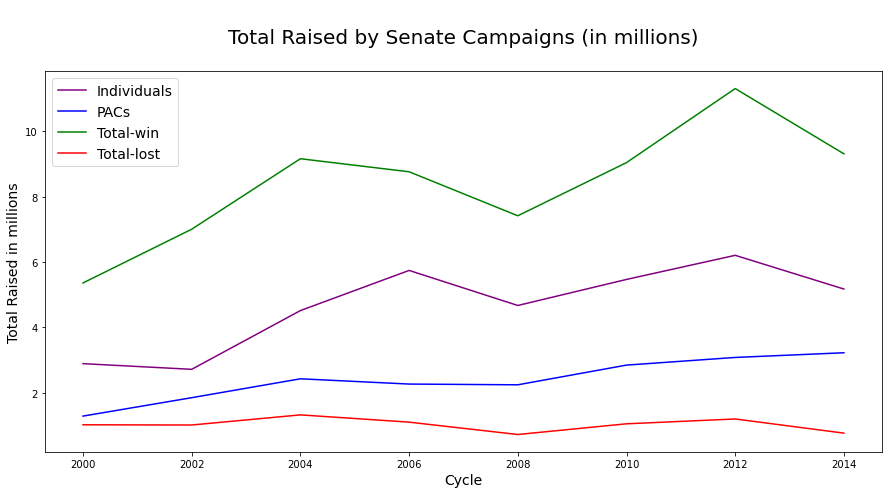

In [29]:
fig, ax = plt.subplots(figsize=(15,7))
avg_raised_sen_races['raised_total_1M'].unstack().plot(
    ax=ax, color=['red', 'green'])
avg_raised_sen_races['raised_pacs_1M'].unstack()['Y'].plot(
    ax=ax, color='blue')
avg_raised_sen_races['raised_indiv_1M'].unstack()['Y'].plot(
    ax=ax, color='purple')
plt.xticks(rotation = 0)
plt.xticks(rotation = 0)
plt.title("\nTotal Raised by Senate Campaigns (in millions)\n", fontsize=20)
plt.ylabel("Total Raised in millions", fontsize=14)
plt.xlabel("Cycle", fontsize=14)
handles, labels = ax.get_legend_handles_labels()
labels = ['Total-lost', 'Total-win', 'PACs', 'Individuals']
ax.legend(reversed(handles), reversed(labels), fontsize=14, loc='best');

A successful Senate campaign is expected to raise between $6-10 million dollars, with 60 percent of that money originating from individual donors, and another 30 percent from PAC/corporate sponsors.<br><br>

In [30]:
avg_raised_house_races = in_cycle[in_cycle['campaign']=='CON'].groupby(
    by=['cycle', 'won'])[['raised_total_1M', 'raised_pacs_1M','raised_indiv_1M']].mean().sort_values(
    by=['cycle', 'won'], ascending=False)
avg_raised_house_races

raised_total_1M  raised_pacs_1M  raised_indiv_1M
cycle won                                                  
2014  Y           1.636449        0.764213         0.757677
      N           0.184621        0.119499         0.221689
2012  Y           1.741314        0.755736         0.824851
      N           0.209505        0.155785         0.200374
2010  Y           1.480438        0.636459         0.717659
      N           0.203522        0.164405         0.199283
2008  Y           1.574958        0.713039         0.773415
      N           0.235232        0.156583         0.251834
2006  Y           1.329278        0.606643         0.628920
      N           0.211342        0.157927         0.214587
2004  Y           1.173401        0.535926         0.546942
      N           0.150030        0.135134         0.153621
2002  Y           0.908031        0.444760         0.398899
      N           0.112126        0.086066         0.130395
2000  Y           1.185452        0.412312         0.359384
      N           0.158337        0.085212         0.126598

In [31]:
round(avg_raised_house_races['raised_pacs_1M'].mean() / avg_raised_house_races['raised_total_1M'].mean(), 4)

0.4746

In [32]:
round(avg_raised_house_races['raised_indiv_1M'].mean() / avg_raised_house_races['raised_total_1M'].mean(), 4)

0.5207

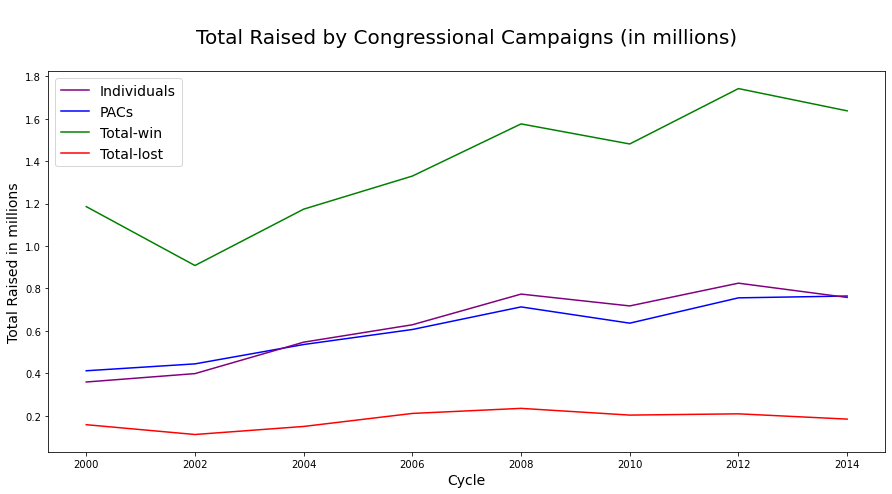

In [33]:
fig, ax = plt.subplots(figsize=(15,7))
avg_raised_house_races['raised_total_1M'].unstack().plot(
    ax=ax, color=['red', 'green'])
avg_raised_house_races['raised_pacs_1M'].unstack()['Y'].plot(
    ax=ax, color='blue')
avg_raised_house_races['raised_indiv_1M'].unstack()['Y'].plot(
    ax=ax, color='purple')
plt.xticks(rotation = 0)
plt.xticks(rotation = 0)
plt.title("\nTotal Raised by Congressional Campaigns (in millions)\n", fontsize=20)
plt.ylabel("Total Raised in millions", fontsize=14)
plt.xlabel("Cycle", fontsize=14)
handles, labels = ax.get_legend_handles_labels()
labels = ['Total-lost', 'Total-win', 'PACs', 'Individuals']
ax.legend(reversed(handles), reversed(labels), fontsize=14, loc='best');

A successful Congressional campaign is expected to raise between $1-2 million dollars, with half of that money originating equally from both individual donors and PAC/corporate sponsors.

---
# Calculate Most & Least Expensive States

In [34]:
global all_districts

In [35]:
districts = list(candidates['district'].unique())
index = [districts.index('na-an'), districts.index(np.nan)]

all_districts = sorted(np.delete(districts, index))

In [36]:
def top_district_spend(df, cycle, amount_col):
    return df[(df['won']=='Y') & (df['cycle']==cycle)].groupby(
    by='district')[['district', amount_col]].mean()

In [37]:
def empty_districts(series):
    new_series = []
    i=0
    
    for district in all_districts:
        if district in series.index:
            new_series.append(series.iloc[i][0])
            i += 1
        else:
            new_series.append(np.nan)

    return pd.Series(data=new_series, index=all_districts)

In [38]:
def top_spend_house_cycles(df, years_list):
    all_races = df[df['campaign']=='CON']
    house_states = top_district_spend(all_races, years[0], 'raised_total_1M')
    district_list = empty_districts(house_states)
    df = pd.DataFrame(data=district_list.values.ravel(), index=district_list.index, columns=[str(years[0])])
    
    for year in years_list[1:]:
        total_nums = top_district_spend(all_races, year, 'raised_total_1M')
        all_nums = empty_districts(total_nums)
        df[str(year)] = all_nums.values.ravel()
    
    return df

In [39]:
years = [2014, 2012, 2010, 2008, 2006, 2004, 2002, 2000]

#### Congressional Races

In [40]:
states_congr_races = top_spend_house_cycles(in_cycle, years)
states_congr_races

,2014,2012,2010,2008,2006,2004,2002,2000
AK-01,0.733970,0.975759,0.959281,1.387126,1.736848,2.423879,2.112805,1.775478
AL-01,2.147078,1.106885,0.901365,0.823662,1.041482,1.143278,1.616997,0.461638
AL-02,1.101419,1.013043,1.295073,2.019435,0.698845,0.719898,0.428189,0.702436
AL-03,1.091324,1.083664,1.118750,1.364502,1.362801,2.118644,1.904014,0.814458
AL-04,1.142344,1.129451,0.671013,0.572507,0.702623,0.670084,0.601218,2.226830
...,...,...,...,...,...,...,...,...
WI-09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.582999
WV-01,1.534194,2.175718,1.152437,0.773961,1.485119,0.553361,0.355532,0.374586
WV-02,2.228710,2.435652,1.538969,2.968802,2.287783,1.577184,2.923648,1.969804
WV-03,1.938500,1.499469,1.697318,0.708721,0.474773,0.484370,0.396252,0.630657


In [41]:
# Aggregate the total sum and average across each row
grand_total_congr = states_congr_races.sum(axis=1)
grand_avg_congr = states_congr_races.mean(axis=1)
states_congr_races['TOTAL'] = grand_total_congr
states_congr_races['AVG'] = grand_avg_congr

# Sort by Highest-to-Lowest Average Funds Raised, per million
# Then add a ranking index column
states_congr_races = states_congr_races.sort_values(by='AVG', ascending=True)
states_congr_races['house_rank'] = np.arange(1, len(states_congr_races.index)+1)

In [42]:
states_congr_races.head() # Least expensive districts

,2014,2012,2010,2008,2006,2004,2002,2000,TOTAL,AVG,house_rank
PA-19,NaN,NaN,0.223967,0.213691,0.304843,0.216469,0.239174,0.474620,1.672764,0.278794,1
MS-05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.373822,0.373822,0.373822,2
IL-04,0.248846,0.343144,0.526095,0.307118,0.168711,0.285513,0.667942,0.589392,3.136761,0.392095,3
VA-03,0.480208,0.437573,0.440791,0.523226,0.340378,0.489832,0.168772,0.305759,3.186539,0.398317,4
TN-01,0.505920,0.709886,0.507504,0.580372,0.418290,0.197849,0.141334,0.178310,3.239465,0.404933,5


In [43]:
states_congr_races.tail(10) # Most expensive districts

,2014,2012,2010,2008,2006,2004,2002,2000,TOTAL,AVG,house_rank
IL-14,1.111930,1.306146,1.705584,4.758588,4.962528,4.799638,2.883418,3.202692,24.730524,3.091315,451
FL-22,1.297200,3.587617,3.723255,3.976886,4.688511,1.546664,1.971540,4.013311,24.804984,3.100623,452
NM-01,1.616427,1.855621,3.192926,4.255699,5.554746,3.400679,2.526560,2.977697,25.380355,3.172544,453
IL-10,5.409063,3.145389,3.055248,5.542292,3.123730,1.704521,1.860723,3.499628,27.340594,3.417574,454
AZ-09,4.513737,2.439434,NaN,NaN,NaN,NaN,NaN,NaN,6.953171,3.476585,455
VA-07,1.477905,7.871105,6.105727,4.095363,3.336658,2.670336,1.404783,1.892938,28.854815,3.606852,456
UT-04,4.835449,2.957995,NaN,NaN,NaN,NaN,NaN,NaN,7.793444,3.896722,457
MN-06,1.788428,14.248831,11.943891,3.578401,2.991166,2.521347,1.795606,1.836082,40.703752,5.087969,458
OH-08,18.573508,21.344947,8.875068,3.917752,3.192138,1.503845,1.168897,1.540705,60.116860,7.514608,459
MA-11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,NaN,460


In [44]:
# Drop the last null row
states_congr_races.drop(states_congr_races.tail(1).index, axis=0, inplace=True)

In [45]:
# Create dictionary for Congressional state rankings
house_rank = {}

for i, state in enumerate(states_congr_races.index):
    house_rank[state] = (states_congr_races['house_rank'][i])/len(states_congr_races['house_rank'])
    
list(house_rank.items())[-5:]

[('AZ-09', 0.9912854030501089),
 ('VA-07', 0.9934640522875817),
 ('UT-04', 0.9956427015250545),
 ('MN-06', 0.9978213507625272),
 ('OH-08', 1.0)]

#### Senate Races

In [46]:
def empty_states(series):
    states_50 = ['AK', 'AL', 'AR', 'AZ', 'CA', 'CO', 'CT', 'DE', 'FL', 'GA', 'HI', 'IA', 'ID', 'IL', 'IN',
                 'KS', 'KY', 'LA', 'MA', 'MD', 'ME', 'MI', 'MN', 'MO', 'MS', 'MT', 'NC', 'ND', 'NE', 'NH', 'NJ',
                 'NM', 'NV', 'NY', 'OH', 'OK', 'OR', 'PA', 'RI', 'SC', 'SD', 'TN', 'TX', 'UT', 'VA', 'VT', 'WA',
                 'WI', 'WV', 'WY']

    new_series = []
    i=0
    
    for state in states_50:
        if state in series.index:
            new_series.append(series[i])
            i += 1
        else:
            new_series.append(np.nan)

    return pd.Series(data=new_series, index=states_50)

In [47]:
def top_states_spend(df, cycle, amount_col):
    return df[(df['won']=='Y') & (df['cycle']==cycle)].groupby(
    by='state')[['state', amount_col]].mean().sort_index()

In [48]:
def top_spend_sen_cycles(df, years_list):
    sen_races = df[df['campaign']=='SEN']
    sen_states = top_states_spend(sen_races, years_list[0], 'raised_total_1M')
    all_states = empty_states(sen_states.iloc[:, 0])
    df = pd.DataFrame(data=all_states.values.ravel(), index=all_states.index, columns=[str(years[0])])
    
    for year in years_list[1:]:
        sen_nums = top_states_spend(sen_races, year, 'raised_total_1M')
        all_nums = empty_states(sen_nums.iloc[:, 0])
        df[str(year)] = all_nums.values.ravel()
    
    return df

In [49]:
states_sen_races = top_spend_sen_cycles(in_cycle, years)
states_sen_races.head()

,2014,2012,2010,2008,2006,2004,2002,2000
AK,9.326219,NaN,5.936500,3.889782,NaN,9.457633,2.604025,NaN
AL,1.321156,NaN,4.656422,4.802507,NaN,11.098061,7.273167,NaN
AR,17.767321,NaN,4.228044,4.840011,NaN,7.893183,7.403163,NaN
AZ,NaN,14.651566,5.239565,NaN,14.424722,2.392189,NaN,2.641919
CA,NaN,6.194096,24.179959,NaN,5.706847,23.363069,NaN,6.401668


In [50]:
# Aggregate the total sum and average across each row
grand_total_sen = states_sen_races.sum(axis=1)
grand_avg_sen = states_sen_races.mean(axis=1)
states_sen_races['TOTAL'] = grand_total_sen
states_sen_races['AVG'] = grand_avg_sen

# Sort by Highest-to-Lowest Average Funds Raised, per million
# Then add a ranking index column
states_sen_races = states_sen_races.sort_values(by='AVG', ascending=True)
states_sen_races['sen_rank'] = np.arange(1, len(states_sen_races.index)+1)

In [51]:
states_sen_races.head(10) # Least expensive states

,2014,2012,2010,2008,2006,2004,2002,2000,TOTAL,AVG,sen_rank
WY,3.198433,4.307612,NaN,2.152767,1.540264,NaN,1.425267,1.182823,13.807166,2.301194,1
ID,1.965730,NaN,2.939433,2.950136,NaN,2.370530,4.157519,NaN,14.383348,2.876670,2
HI,6.558313,6.627095,3.489578,NaN,2.743045,2.566738,NaN,0.458980,22.443749,3.740625,3
MS,7.667622,3.402397,NaN,4.379668,2.706476,NaN,2.349973,2.022734,22.528870,3.754812,4
RI,3.528287,4.313548,NaN,3.780110,6.670665,NaN,3.345887,2.539170,24.177667,4.029611,5
VT,NaN,5.454069,2.927806,NaN,4.979135,4.082164,NaN,2.733708,20.176882,4.035376,6
WV,6.868714,5.051018,4.945720,4.959647,4.518055,NaN,2.321349,1.559973,30.224476,4.317782,7
ND,NaN,6.803784,3.737309,NaN,4.290456,4.146978,NaN,2.749943,21.728470,4.345694,8
OK,3.577998,NaN,2.625510,5.174025,NaN,7.202507,4.384452,NaN,22.964492,4.592898,9
KS,7.598441,NaN,3.965561,5.717257,NaN,4.014910,1.746018,NaN,23.042187,4.608437,10


In [52]:
states_sen_races.tail(10) # Most expensive states

,2014,2012,2010,2008,2006,2004,2002,2000,TOTAL,AVG,sen_rank
WA,NaN,8.601384,14.264370,NaN,14.030853,16.618949,NaN,8.072783,61.588339,12.317668,41
VA,14.894451,21.562195,NaN,13.913598,7.214926,NaN,2.164068,17.109259,76.858497,12.809750,42
CA,NaN,6.194096,24.179959,NaN,5.706847,23.363069,NaN,6.401668,65.845639,13.169128,43
OH,NaN,24.082184,17.108340,NaN,14.142177,6.861382,NaN,3.862047,66.056130,13.211226,44
CO,13.904090,NaN,16.067574,12.910974,NaN,18.779027,7.826074,NaN,69.487739,13.897548,45
PA,NaN,10.207508,21.294090,NaN,15.455111,15.421498,NaN,7.415111,69.793318,13.958664,46
NC,14.480579,NaN,10.283572,10.113815,NaN,14.576166,21.640133,NaN,71.094265,14.218853,47
MA,22.241873,44.724683,9.797473,3.905684,7.586674,NaN,8.691836,4.766593,101.714816,14.530688,48
FL,NaN,16.805596,18.621887,NaN,14.171718,16.370702,NaN,10.808015,76.777918,15.355584,49
NY,NaN,15.219142,14.980225,NaN,33.690345,9.774194,NaN,23.768527,97.432433,19.486487,50


In [53]:
# Create dictionary for Senate state rankings
senate_rank = {}

for i, state in enumerate(states_sen_races.index):
    senate_rank[state] = states_sen_races['sen_rank'][i]/len(states_sen_races['sen_rank'])
    
list(senate_rank.items())[-10:]

[('WA', 0.82),
 ('VA', 0.84),
 ('CA', 0.86),
 ('OH', 0.88),
 ('CO', 0.9),
 ('PA', 0.92),
 ('NC', 0.94),
 ('MA', 0.96),
 ('FL', 0.98),
 ('NY', 1.0)]

---
# Prepare DataFrame for Model

In [54]:
# Binarize campaign (1 for Senate) and Won columns
in_cycle['campaign'] = in_cycle['campaign'].apply(lambda x: 1 if x=='SEN' else 0)
in_cycle['won'] = in_cycle['won'].apply(lambda x: 1 if x=='Y' else 0)
in_cycle.head(4)

,cycle,cid,candidate_name,party,state,district,campaign,cycle_candidate,recip_code,won,nopacs,raised_from_pacs,raised_from_individuals,raised_total,raised_unitemized,raised_total_1M,raised_pacs_1M,raised_indiv_1M
0,2000,N00005009,Richmond A Soluade Sr,R,MO,MO-01,0,Y,RL,0,,NaN,NaN,0,NaN,0.000000,NaN,NaN
1,2012,N00031589,Jonathan Paton,R,AZ,AZ-01,0,Y,RL,0,,1512575.0,871743.0,2487392,103074.0,2.487392,1.512575,0.871743
2,2012,N00031623,Chip Cravaack,R,MN,MN-08,0,Y,RL,0,,1039956.0,959069.0,2505483,506458.0,2.505483,1.039956,0.959069
3,2012,N00018125,George Harper,R,TX,TX-14,0,Y,RL,0,,1000.0,35102.0,36102,0.0,0.036102,0.001000,0.035102


### Deal with third-party candidates

In [55]:
in_cycle['party'].value_counts()

R    7020
D    6054
3    1576
L    1347
I     995
U       1
Name: party, dtype: int64

Almost 4,000 candidates not affliated with either political party.

In [56]:
third_parties = ['I', 'L', '3', 'U']
boolean_filter = in_cycle.party.isin(third_parties)
independent_candidates = in_cycle[boolean_filter]
independent_candidates

,cycle,cid,candidate_name,party,state,district,campaign,cycle_candidate,recip_code,won,nopacs,raised_from_pacs,raised_from_individuals,raised_total,raised_unitemized,raised_total_1M,raised_pacs_1M,raised_indiv_1M
6,2012,N00034513,Daniel Botelho,I,MA,MA-09,0,Y,3L,0,,NaN,2260.0,3535,1275.0,0.003535,NaN,0.002260
17,2012,N00034495,Bill Bloomfield,I,CA,CA-33,0,Y,3L,0,,NaN,7948685.0,7961894,13209.0,7.961894,NaN,7.948685
27,2012,N00032819,Jack Rooney,I,IN,NaN,1,Y,3L,0,,NaN,6000.0,6000,0.0,0.006000,NaN,0.006000
48,2000,N00005095,John Hendricks,L,MO,MO-08,0,Y,3L,0,,NaN,NaN,0,NaN,0.000000,NaN,NaN
50,2000,N00004099,Brian D Ellison,3,MI,MI-05,0,Y,3L,0,,NaN,NaN,0,NaN,0.000000,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16980,2012,N00033825,Steven Reynolds,3,OR,OR-01,0,Y,3L,0,,NaN,250.0,250,NaN,0.000250,NaN,0.000250
16983,2014,N00034173,Avery Ayers,I,TX,NaN,1,Y,3L,0,,NaN,75.0,75,NaN,0.000075,NaN,0.000075
16985,2006,N00027794,Warren Grayson,I,AL,AL-06,0,Y,3L,0,,NaN,600.0,600,NaN,0.000600,NaN,0.000600
16987,2006,N00027955,Rich Haas,L,TX,TX-26,0,Y,3L,0,,NaN,541.0,541,NaN,0.000541,NaN,0.000541


In [57]:
# Manually reassign Bernie Sanders, Angus King, & Joe Lieberman to Democratic party
bernie = in_cycle[in_cycle['candidate_name']=='Bernie Sanders'].index
angus = in_cycle[in_cycle['candidate_name']=='Angus King'].index
lieberman = in_cycle[in_cycle['candidate_name']=='Joe Lieberman'].index
reassign_index = bernie.values.tolist() + angus.values.tolist() + lieberman.values.tolist()

for i in reassign_index:
    in_cycle.iloc[i, 3] = 'D'
    
# Manually reassign Lisa Murkowski to Republican party
m = in_cycle[in_cycle['candidate_name']=='Lisa Murkowski'].index

in_cycle.iloc[m, 3] = 'R'

In [58]:
# That leaves very few winning campaigns outside the 2-party structure
boolean_filter = in_cycle.party.isin(third_parties)
independent_candidates = in_cycle[boolean_filter]
independent_candidates[independent_candidates['won']==1]

,cycle,cid,candidate_name,party,state,district,campaign,cycle_candidate,recip_code,won,nopacs,raised_from_pacs,raised_from_individuals,raised_total,raised_unitemized,raised_total_1M,raised_pacs_1M,raised_indiv_1M
5137,2000,N00002167,Virgil H Goode Jr,I,VA,VA-05,0,Y,3W,1,,267357.0,221753.0,841647,352537.0,0.841647,0.267357,0.221753
9732,2002,N00013701,Daniel E Malone,3,MI,MI-11,0,Y,3W,1,,NaN,NaN,0,NaN,0.000000,NaN,NaN
13557,2002,N00025742,William Christopher Boyd,3,MI,MI-11,0,Y,3W,1,,2.0,NaN,2,NaN,0.000002,0.000002,NaN


In [59]:
# Combine 3rd party and independents into one "Other" category
in_cycle['party'] = [letter if (letter=='D' or letter=='R') else 'O' for letter in in_cycle['party']]

In [60]:
in_cycle['party'].value_counts()

R    7021
D    6061
O    3911
Name: party, dtype: int64

In [61]:
features = in_cycle[['cycle', 'party', 'state', 'district', 'campaign', 'won', 'raised_total_1M']]
party = pd.get_dummies(features['party'])
party

,D,O,R
0,0,0,1
1,0,0,1
2,0,0,1
3,0,0,1
4,0,0,1
...,...,...,...
16988,1,0,0
16989,0,0,1
16990,0,1,0
16991,0,0,1


In [62]:
party.rename(columns={'D':'Dem', 'O':'Other', 'R':'Repub'}, inplace=True)
features = pd.concat([features, party], axis=1)
features.rename(columns={'campaign':'senate'}, inplace=True)
features.drop(columns='party', inplace=True)
features

,cycle,state,district,senate,won,raised_total_1M,Dem,Other,Repub
0,2000,MO,MO-01,0,0,0.000000,0,0,1
1,2012,AZ,AZ-01,0,0,2.487392,0,0,1
2,2012,MN,MN-08,0,0,2.505483,0,0,1
3,2012,TX,TX-14,0,0,0.036102,0,0,1
4,2012,OH,OH-12,0,0,0.014710,0,0,1
...,...,...,...,...,...,...,...,...,...
16988,2008,TN,NaN,1,0,0.000950,1,0,0
16989,2010,OR,OR-01,0,0,0.002300,0,0,1
16990,2010,FL,FL-03,0,0,0.000500,0,1,0
16991,2010,NC,NC-10,0,0,0.049929,0,0,1


In [63]:
def map_state_rank(df, senate_rank, house_rank):
    i=0
    state_rank = []
    while i<len(df):
        
        row = df.iloc[i,:]
        
        if row['senate']==1:
            state_rank.append(senate_rank[row['state']])
        else:
            state_rank.append(house_rank[row['district']])
            
        i += 1
            
    return pd.Series(state_rank)

In [64]:
features['comp_score'] = map_state_rank(features[['senate', 'state', 'district']], senate_rank, house_rank)
features

,cycle,state,district,senate,won,raised_total_1M,Dem,Other,Repub,comp_score
0,2000,MO,MO-01,0,0,0.000000,0,0,1,0.032680
1,2012,AZ,AZ-01,0,0,2.487392,0,0,1,0.938998
2,2012,MN,MN-08,0,0,2.505483,0,0,1,0.636166
3,2012,TX,TX-14,0,0,0.036102,0,0,1,0.978214
4,2012,OH,OH-12,0,0,0.014710,0,0,1,0.949891
...,...,...,...,...,...,...,...,...,...,...
16988,2008,TN,NaN,1,0,0.000950,1,0,0,0.520000
16989,2010,OR,OR-01,0,0,0.002300,0,0,1,0.681917
16990,2010,FL,FL-03,0,0,0.000500,0,1,0,0.104575
16991,2010,NC,NC-10,0,0,0.049929,0,0,1,0.370370


In [65]:
features.drop(columns=['state', 'district'], inplace=True)
features

,cycle,senate,won,raised_total_1M,Dem,Other,Repub,comp_score
0,2000,0,0,0.000000,0,0,1,0.032680
1,2012,0,0,2.487392,0,0,1,0.938998
2,2012,0,0,2.505483,0,0,1,0.636166
3,2012,0,0,0.036102,0,0,1,0.978214
4,2012,0,0,0.014710,0,0,1,0.949891
...,...,...,...,...,...,...,...,...
16988,2008,1,0,0.000950,1,0,0,0.520000
16989,2010,0,0,0.002300,0,0,1,0.681917
16990,2010,0,0,0.000500,0,1,0,0.104575
16991,2010,0,0,0.049929,0,0,1,0.370370


In [66]:
features.to_csv('../data/campaign_total_raised_Model.csv', index=False)

---
# Modeling - First pass

In [67]:
from sklearn.linear_model import LinearRegression, LogisticRegression, Ridge, RidgeCV
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error

In [68]:
model_df = pd.read_csv('../data/campaign_total_raised_Model.csv')

In [69]:
model_df = pd.concat([model_df, pd.get_dummies(model_df['cycle'], drop_first=True)], axis=1)

In [70]:
model_df.drop(columns=['cycle','Other'], inplace=True)
model_df

,senate,won,raised_total_1M,Dem,Repub,comp_score,2002,2004,2006,2008,2010,2012,2014
0,0,0,0.000000,0,1,0.032680,0,0,0,0,0,0,0
1,0,0,2.487392,0,1,0.938998,0,0,0,0,0,1,0
2,0,0,2.505483,0,1,0.636166,0,0,0,0,0,1,0
3,0,0,0.036102,0,1,0.978214,0,0,0,0,0,1,0
4,0,0,0.014710,0,1,0.949891,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
16988,1,0,0.000950,1,0,0.520000,0,0,0,1,0,0,0
16989,0,0,0.002300,0,1,0.681917,0,0,0,0,1,0,0
16990,0,0,0.000500,0,0,0.104575,0,0,0,0,1,0,0
16991,0,0,0.049929,0,1,0.370370,0,0,0,0,1,0,0


### Linear regression model to predict amount of money needed to win a race

In [71]:
winning_model = model_df[model_df['won']==1]

In [72]:
X = winning_model.drop(columns=['raised_total_1M', 'won'])
y = winning_model['raised_total_1M']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42)

In [73]:
sc = StandardScaler()

Z_train = sc.fit_transform(X_train)
Z_test = sc.transform(X_test)

lr = LinearRegression()
lr.fit(Z_train, y_train)

lr.score(Z_train, y_train)

0.5613504957311908

In [74]:
lr.score(Z_test, y_test)

0.6430987075815532

In [75]:
y_preds = lr.predict(Z_test)

In [76]:
plot_vals =  X_test['senate'].apply(lambda x:'senate' if x==1 else 'congress')

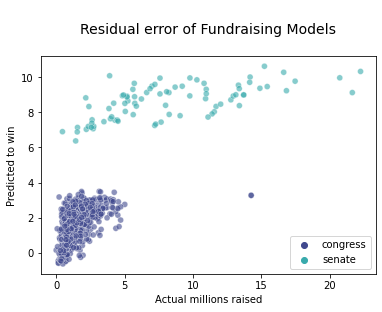

In [77]:
sns.scatterplot(x=y_test, y=y_preds, alpha=.6, hue=plot_vals, palette='mako');
plt.title("\nResidual error of Fundraising Models\n", fontsize=14)
plt.xlabel("Actual millions raised", fontsize=10)
plt.legend()
plt.ylabel("Predicted to win", fontsize=10);

In [78]:
mean_squared_error(y_test, y_preds, squared=False)*1_000_000

1596667.0339514911

In [79]:
coefs = pd.DataFrame(data=(list((zip(X.columns, sc.inverse_transform(lr.coef_.ravel()))))))
coefs.columns=['Variable', 'Coefficient']
coefs.set_index('Variable', inplace = True)

coefs.sort_values(by='Coefficient', ascending=False)

,Coefficient
Variable,
comp_score,0.751129
Dem,0.710583
Repub,0.666141
senate,0.529177
2012,0.221636
2014,0.208101
2010,0.188520
2008,0.182677
2006,0.158045


In [80]:
# Range of 100 numbers between 100 and 250
ridge_alphas = np.linspace(100, 250, 100)

# Cross-validate over range of ridge alphas
ridge_cv = RidgeCV(alphas=ridge_alphas, scoring='r2', cv=10)

# Fit ridge model to optimal alpha value
ridge_cv.fit(Z_train, y_train)

ridge_cv.alpha_

221.21212121212122

In [81]:
ridge = Ridge(alpha=221)
ridge.fit(Z_train, y_train)

Ridge(alpha=221)

In [82]:
ridge.score(Z_train, y_train)

0.5578866663894386

### Classification Model to predict whether or not a campaign will win

In [83]:
X2 = model_df.drop(columns='won')
y2 = model_df['won']

In [84]:
X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y2, random_state = 15)

In [85]:
lg = LogisticRegression()
lg.fit(X2_train[['raised_total_1M']], y2_train)

lg.score(X2_train[['raised_total_1M']], y2_train)

0.8024952919020716

In [86]:
lg.score(X2_test[['raised_total_1M']], y2_test)

0.7914803483172511

In [87]:
lg.predict_proba(X2_test[['raised_total_1M']])[:5]

array([[0.83452234, 0.16547766],
       [0.86360746, 0.13639254],
       [0.86320563, 0.13679437],
       [0.86360746, 0.13639254],
       [0.68270466, 0.31729534]])

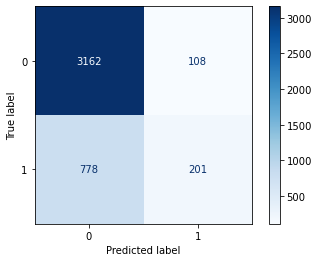

In [88]:
plot_confusion_matrix(lg, X2_test[['raised_total_1M']], y2_test, cmap='Blues');

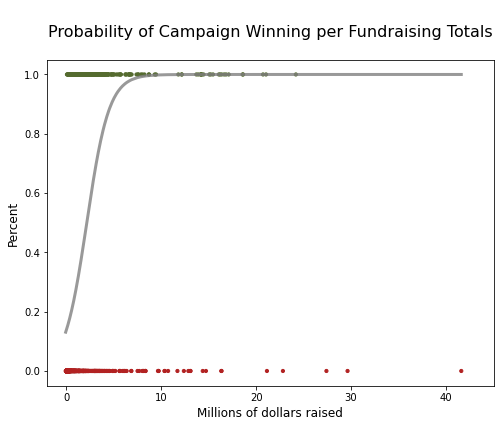

In [89]:
colors = {1:'darkolivegreen', 0:'firebrick'}

plt.figure(figsize = (8, 6))
plt.scatter(X2_test[['raised_total_1M']], y2_test, s = 10, c=y2_test.apply(lambda x: colors[x]));
plt.plot(X2_test[['raised_total_1M']].sort_values('raised_total_1M'),
          lg.predict_proba(X2_test[['raised_total_1M']].sort_values('raised_total_1M'))[:,1],
          color = 'grey', alpha = 0.8, lw = 3)
plt.title("\nProbability of Campaign Winning per Fundraising Totals\n", fontsize=16)
plt.xlabel("Millions of dollars raised", fontsize=12)
plt.ylabel("Percent", fontsize=12)
plt.xlim(-2, 45);